In [ ]:
import pandas as pd 
import numpy as np 
import keras 
import sklearn

time: 4.21 ms


In [ ]:
# run this once

!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.67 s


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.86 ms


In [ ]:
path = "/content/drive/My Drive/Diabetes/diabetes.csv"
raw_data = pd.read_csv(path)

time: 32.7 ms


# Profiling Dataset
Install pandas profiling version 2.7.1 first and restart kernel.

In [ ]:
# run this once

!pip install pandas-profiling==2.7.1

time: 2.75 s


In [ ]:
import pandas_profiling

report = raw_data.profile_report(sort='None', html={'style':{'full_width': True}}, progress_bar=False)
report

time: 21.7 s


# Drop Columns

In [ ]:
data_skin = raw_data.drop(['SkinThickness'], axis = 1)
data_ins = raw_data.drop(['Insulin'], axis = 1)
data_skin_ins = raw_data.drop(['SkinThickness', 'Insulin'], axis = 1)
# print((raw_data == 0).sum(axis = 0))
# print((data_ins == 0).sum(axis = 0))
# print((data_skin == 0).sum(axis = 0))
# print((data_skin_ins == 0).sum(axis = 0))
data = []
data.extend((raw_data, data_ins, data_skin, data_skin_ins))

time: 8.28 ms


# Split-Impute-Standardize Dataset

In [ ]:
# split dataset 80-20

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

np.random.seed(42)
X_train_set = []
X_test_set= []
y_train_set = []
y_test_set= []

for d in data:
    X = d.iloc[:, :-1].to_numpy() 
    y = d.iloc[:, -1].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)
    
    # imputer = SimpleImputer(missing_values = 0, strategy = 'mean')
    # X_train[:, 1:-1] = imputer.fit_transform(X_train[:, 1:-1])
    # X_test[:, 1:-1] = imputer.fit_transform(X_test[:, 1:-1])
    
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    X_train_set.append(X_train)
    X_test_set.append(X_test)
    y_train_set.append(y_train)
    y_test_set.append(y_test)

time: 28.4 ms


# Generic Performance Class

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

split = 4

class Performance:
    
    def __init__(self, clf_type, xtrain, xtest, ytrain, ytest):
        self.clf = clf_type
        self.xtrain = xtrain
        self.xtest = xtest
        self.ytrain = ytrain
        self.ytest = ytest
        self.train_accuracy = None
        self.test_accuracy = None
        self.cv_accuracy = None
        self.fs = None
        self.cm = np.zeros((2,2))
        # self.cm_accuracy = None
        self.calculations()

    def calculations(self):
        # fit classifier to model
        self.clf.fit(self.xtrain, self.ytrain)
        
        # training accuracy
        pred = self.clf.predict(self.xtrain)
        self.train_accuracy = round(accuracy_score(self.ytrain, pred) * 100, 2)
        
        # testing accuracy
        pred = self.clf.predict(self.xtest)
        self.test_accuracy = round(accuracy_score(self.ytest, pred) * 100, 2)

        # cross validation accuracy
        kf = KFold(n_splits = split, random_state = 42, shuffle = True)
        cv_score = cross_val_score(self.clf, self.xtrain, self.ytrain, cv = kf)
        self.cv_accuracy = round(cv_score.mean() * 100, 2)

        # f1 score
        self.fs = round(f1_score(self.ytest, pred) * 100, 2)

        # confusion matrix
        self.cm = confusion_matrix(self.ytest, pred)
        # self.cm_accuracy = np.round((self.cm.trace()/self.cm.sum()) * 100, 2)

time: 33.4 ms


# Applying Classfication Algorithms

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import svm

classifiers = [MLPClassifier(hidden_layer_sizes = (150, 100, 50), max_iter = 300, activation = 'logistic', solver = 'adam', random_state = 42), 
               RandomForestClassifier(), KNeighborsClassifier(), GaussianNB(), XGBClassifier(), svm.SVC(probability = True)]
names = ['MLP', 'Random Forest', 'KNN','Naive Bayes', 'XGBoost', 'SVM']
models = []
train_accuracy = []
test_accuracy = []
cv_accuracy = []
fs = []
# cm_accuracy = []
cm = []

for a, b, c, d in zip(X_train_set, X_test_set, y_train_set, y_test_set):
    for clf in classifiers:
        model = Performance(clf, a, b, c, d)
        models.append(model)
        train_accuracy.append(model.train_accuracy)
        test_accuracy.append(model.test_accuracy)
        fs.append(model.fs)
        cv_accuracy.append(model.cv_accuracy)
        # cm_accuracy.append(model.cm_accuracy)
        cm.append(model.cm)

time: 35 s


# Visualizing Results

In [ ]:
def highlight_max(s): 
    if s.dtype == np.object: 
        is_max = [False for i in range(s.shape[0])] 
    else: 
        is_max = s == s.max()
      
    return ['color: red' if v else '' for v in is_max]

styles = [dict(selector="caption", 
    props=[("text-align", "center"),
    ("font-size", "150%"),
    ("padding-bottom", "20px"),
    ('font-weight', 'bold'),
    ("color", 'mediumblue')])]

time: 6.78 ms


In [ ]:
df = pd.DataFrame({'Classifiers': names, 
                   'Training': train_accuracy[:6], 
                   'Testing': test_accuracy[:6],
                   'Cross Validation': cv_accuracy[:6],
                   'F1-Score': fs[:6]})
    
df.style.\
    set_caption("Raw Data").\
    apply(highlight_max).\
    set_table_styles(styles).\
    set_properties(**{'text-align': 'center'}, **{'width': '150px'})

time: 36 ms


In [ ]:
df = pd.DataFrame({'Classifiers': names, 
                   'Training': train_accuracy[6:12], 
                   'Testing': test_accuracy[6:12],
                   'Cross Validation': cv_accuracy[6:12],
                   'F1-Score': fs[6:12]})

df.style.\
    set_caption("Data Without Insulin Feature").\
    apply(highlight_max).\
    set_table_styles(styles).\
    set_properties(**{'text-align': 'center'}, **{'width': '150px'})

time: 38.7 ms


In [ ]:
df = pd.DataFrame({'Classifiers': names, 
                   'Training': train_accuracy[12:18], 
                   'Testing': test_accuracy[12:18],
                   'Cross Validation': cv_accuracy[12:18],
                   'Confusion Matrix': fs[12:18]})

df.style.\
    set_caption("Data Without Skin Thickness Feature").\
    apply(highlight_max).\
    set_table_styles(styles).\
    set_properties(**{'text-align': 'center'}, **{'width': '150px'})

time: 36.6 ms


In [ ]:
df = pd.DataFrame({'Classifiers': names, 
                   'Training': train_accuracy[18:24], 
                   'Testing': test_accuracy[18:24],
                   'Cross Validation': cv_accuracy[18:24],
                   'F1-Score': fs[18:24]})

df.style.\
    set_caption("Data Without Insuline And Skin Thickness Features").\
    apply(highlight_max).\
    set_table_styles(styles).\
    set_properties(**{'text-align': 'center'}, **{'width': '150px'})

time: 34.7 ms


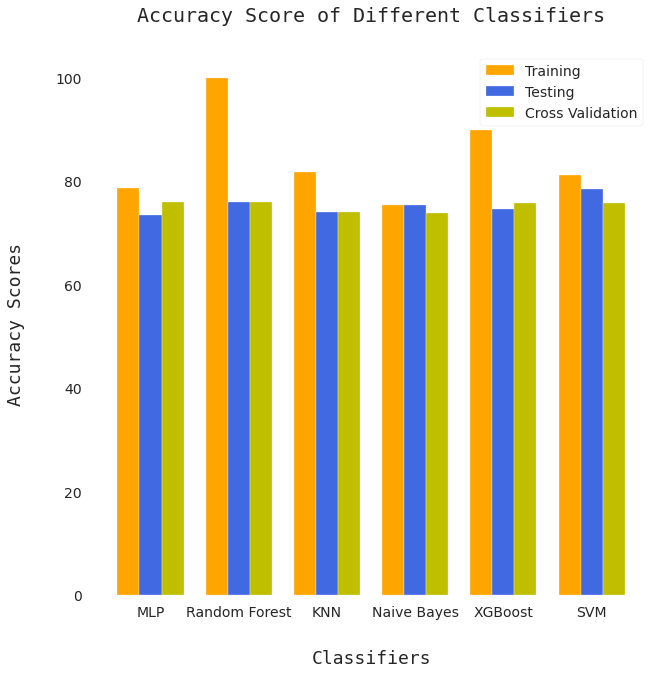

time: 291 ms


In [ ]:
import matplotlib.pyplot as plot
%matplotlib inline

barWidth = 0.25

bars1 = df['Training']
bars2 = df['Testing']
bars3 = df['Cross Validation']

r1 = np.arange(len(df['Classifiers']))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
plot.figure(figsize = (10, 10))
plot.bar(r1, bars1, color ='orange', width = barWidth, edgecolor = 'white', label = 'Training')
plot.bar(r2, bars2, color ='royalblue', width = barWidth, edgecolor = 'white', label = 'Testing')
plot.bar(r3, bars3, color ='y', width = barWidth, edgecolor = 'white', label = 'Cross Validation')

plot.title('Accuracy Score of Different Classifiers', fontweight = 'normal', fontsize = 20, family = 'monospace', pad = 30)
plot.xlabel('Classifiers', fontweight = 'normal', fontsize = 18, family = 'monospace', labelpad = 30)
plot.ylabel('Accuracy Scores', fontweight = 'normal', fontsize = 18, family = 'monospace', labelpad = 30)
plot.xticks([r + barWidth for r in range(len(bars1))], df['Classifiers'], fontsize = 14)
plot.yticks(fontsize = 14)
 
plot.legend(prop={"size": 14})
plot.show()

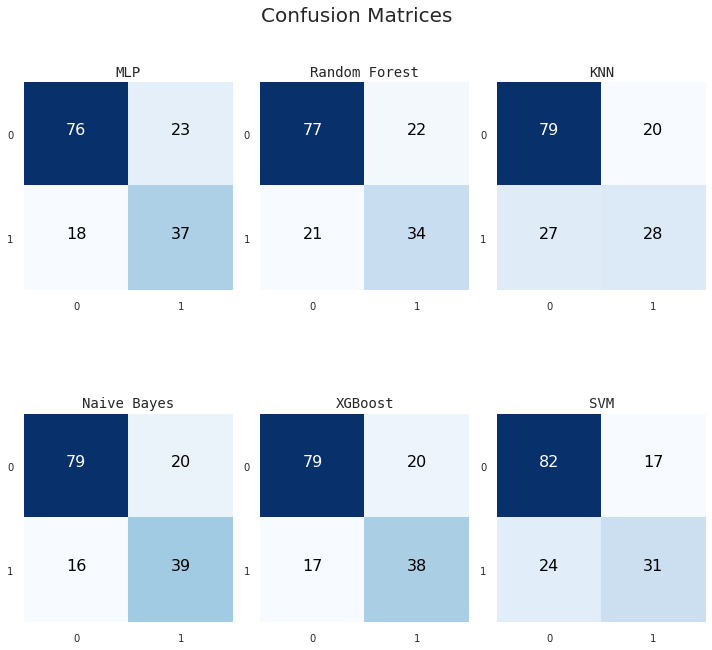

time: 645 ms


In [ ]:
import itertools
target_names = ['0', '1']
cmap = plot.get_cmap('Blues')
fig, axs = plot.subplots(2, 3, figsize=(10, 10))
fig.suptitle('Confusion Matrices', fontsize = 20)  

plot.setp (axs, xticks = np.arange(len(target_names)),
         xticklabels = [0, 1],
         yticks = [0, 1])


for ax, id, name in zip(axs.flatten(), range(len(cm)), names):
    c = cm[id]
    ax.imshow(c, interpolation = 'nearest', cmap = cmap)
    ax.set_title(name, fontsize = 14, family = 'monospace')
    thresh = c.max() / 2
    
    for i, j in itertools.product(range(c.shape[0]), range(c.shape[1])):
        ax.text(j, i, "{:,}".format(c[i, j]),
                    horizontalalignment="center", fontsize = 16,
                    color="white" if c[i, j] > thresh else "black") 
plot.tight_layout()
plot.show()

# User Input Analysis With GUI

In [ ]:
# run this once and restart kernerl

# !pip install -q streamlit

time: 1 ms


In [ ]:
import streamlit as st

sl = st.sidebar.slider

time: 1.63 ms


# Show Input

In [ ]:
# App Headline
st.write("""
# Diabetes Prediction
""")

# create sidebar for  use input

st.sidebar.header('User Input')

input = {'Pregnancies': sl('Pregnancies', 0, 20, 10),
        'Glucose': sl('Glucose', 0, 200, 100),
        'BloodPressure': sl('BloodPressure', 0, 130, 65),
        'SkinThickness': sl('SkinThickness', 0, 100, 50),
        'Insulin':  sl('Insulin', 0, 900, 450),
        'BMI': sl('BMI', 0.0, 70.0, 35.0),
        'DiabetesPedigreeFunction': sl('DiabetesPedigreeFunction', 0.0, 3.5, 1.75),
        'Age': sl('Age', 20, 90, 35)}

del input['SkinThickness']
X_new = pd.DataFrame(input, index=[0]).to_numpy()

# Show user inputs in table
st.subheader('User Input Data')
st.write(X_new)

time: 21.1 ms


# Show Class Labels

In [ ]:
# Show class labels and values

class_labels = {'Label': ['No Diabetes', 'Diabetes'], 
                'Value': [0, 1]}

class_labels = pd.DataFrame(class_labels)
st.subheader('Class Labels')
st.write(class_labels)

time: 7.34 ms


# Show Predictions

In [ ]:
# make predictions using different classifiers

pred_value = []
pred_label = []
pred_prob = []

for model in models[12:18]:
    model.clf.fit(model.xtrain, model.ytrain)
    y_new = model.clf.predict(X_new)
    pred_value.append(y_new[0])
    pred_label.append(class_labels.iloc[y_new[0], 0])
    pred_prob.append(model.clf.predict_proba(X_new))

predictions = {'Classifier': names,
          'Predicted Value': pred_value,
          'Predicted Label': pred_label}

predictions = pd.DataFrame(predictions)

st.subheader('Predictions')
st.write(predictions)

time: 1.7 s


# Show Prediction Probablities

In [ ]:
# prediction probablities using different classifiers

pred_prob = pd.DataFrame(np.row_stack(pred_prob))
pred_prob = {'Classifier': names,
             '0-No Diabetes': pred_prob[0],
             '1-Diabetes': pred_prob[1]}

pred_prob = pd.DataFrame(pred_prob)

st.subheader('Prediction Probabilities')
st.write(pred_prob)


time: 7.59 ms


In [ ]:
# run once 

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2020-09-22 18:36:17--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.233.175.36, 52.54.16.202, 54.236.132.162, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.233.175.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.4’

ngrok-stable-linux- 100%[===================>]  13.13M  18.2MB/s    in 0.7s    

2020-09-22 18:36:18 (18.2 MB/s) - ‘ngrok-stable-linux-amd64.zip.4’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
get_ipython().system_raw('./ngrok http 8501 &')

In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
     'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

In [ ]:
!streamlit run '/content/drive/My Drive/Diabetes/dm_diabetes_prediction.py'